sample: 100%|██████████| 1500/1500 [00:03<00:00, 489.65it/s, 31 steps of size 1.00e-01. acc. prob=0.93] 


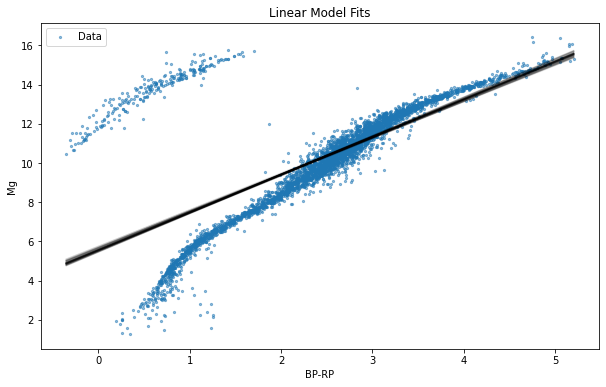

TypeError: <lambda>() got an unexpected keyword argument 'sigma'

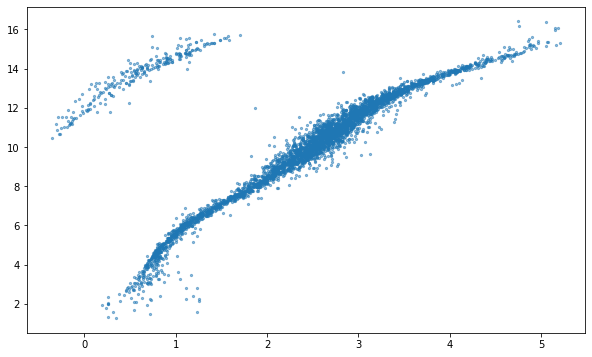

In [10]:
import numpy as np
import jax.numpy as jnp
from jax import random, ops
import matplotlib.pyplot as plt
import numpyro
from numpyro import sample
from numpyro.distributions import Normal, HalfNormal
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

# Data Down-Selection
# Load data
#data = np.load('data/gaiadr3_solar_neighborhood.csv')
#data = np.load('data/gaiadr3_solar_neighborhood.csv', allow_pickle=True)
data = np.genfromtxt('data/gaiadr3_solar_neighborhood.csv', delimiter=',', skip_header=1)
# Select objects with parallax > 40 milliarcseconds
data = data[data[:, 2] > 40]

# Linear model
def linear_model(bp_rp, mg, sigma):
    m = sample('m', Normal(0, 10))
    b = sample('b', Normal(0, 20))
    sigma = sample('sigma', HalfNormal(sigma))
    mu = m * bp_rp + b
    sample('obs', Normal(mu, sigma), obs=mg)

# Quadratic model
def quadratic_model(bp_rp, mg, sigma):
    a = sample('a', Normal(0, 10))
    b = sample('b', Normal(0, 20))
    c = sample('c', Normal(0, 20))
    sigma = sample('sigma', HalfNormal(sigma))
    mu = a * bp_rp**2 + b * bp_rp + c
    sample('obs', Normal(mu, sigma), obs=mg)

# MCMC inference
def run_mcmc(model, args, num_samples=1000, num_warmup=500):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(random.PRNGKey(0), *args)
    return mcmc.get_samples()

# Linear model inference
linear_samples = run_mcmc(linear_model, (data[:, 1], data[:, 0], 1.0))

# Quadratic model inference
quadratic_samples = run_mcmc(quadratic_model, (data[:, 1], data[:, 0], 1.0))

# Plotting
def plot_models(model_samples, model_func, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 1], data[:, 0], s=5, alpha=0.5, label='Data')
    bp_rp_range = np.linspace(data[:, 1].min(), data[:, 1].max(), 100)
    for i in range(50):
        sample_params = {key: model_samples[key][i] for key in model_samples.keys()}
        model_mags = model_func(bp_rp_range, **sample_params)
        plt.plot(bp_rp_range, model_mags, 'k-', alpha=0.1)
    plt.xlabel('BP-RP')
    plt.ylabel('Mg')
    plt.title(f'{model_name} Model Fits')
    plt.legend()
    plt.show()

# Plot linear model fits
#plot_models(linear_samples, lambda x, m, b: m * x + b, "Linear")
plot_models(linear_samples, lambda x, m, b, sigma=None: m * x + b, "Linear")

# Plot quadratic model fits
plot_models(quadratic_samples, lambda x, a, b, c: a * x**2 + b * x + c, "Quadratic")


sample: 100%|██████████| 1500/1500 [00:03<00:00, 403.44it/s, 7 steps of size 3.93e-01. acc. prob=0.92] 


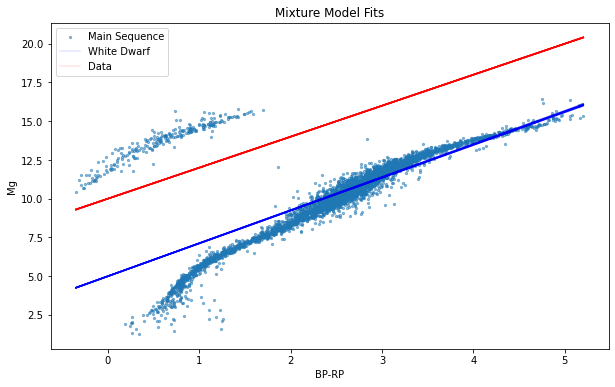

In [13]:
import numpy as np
import jax.numpy as jnp
from jax import random, ops
import matplotlib.pyplot as plt
import numpyro
from numpyro import sample
from numpyro.distributions import Normal, Uniform
from numpyro.infer import MCMC, NUTS

# Load data
data = np.genfromtxt('data/gaiadr3_solar_neighborhood.csv', delimiter=',', skip_header=1)
data = data[data[:, 2] > 40]

# Define mixture model
def mixture_model(bp_rp, mg):
    # Parameters for main sequence stars
    m_ms = sample('m_ms', Uniform(2, 5))
    b_ms = sample('b_ms', Uniform(0, 5))
    sigma_ms = sample('sigma_ms', Uniform(0, 1))
    
    # Parameters for white dwarfs
    m_wd = sample('m_wd', Uniform(2, 5))
    b_wd = sample('b_wd', Uniform(10, 15))
    sigma_wd = sample('sigma_wd', Uniform(0, 1))
    
    # Mixing proportion between main sequence stars and white dwarfs
    w_ms = sample('w_ms', Uniform(0, 1))
    
    # Main sequence model
    mu_ms = m_ms * bp_rp + b_ms
    main_sequence = sample('main_sequence', Normal(mu_ms, sigma_ms), obs=mg)
    
    # White dwarf model
    mu_wd = m_wd * bp_rp + b_wd
    white_dwarf = sample('white_dwarf', Normal(mu_wd, sigma_wd), obs=mg)
    
    # Mixture model
    mixture = w_ms * main_sequence + (1 - w_ms) * white_dwarf
    
    return mixture

# MCMC inference
def run_mcmc(model, args, num_samples=1000, num_warmup=500):
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(random.PRNGKey(0), *args)
    return mcmc.get_samples()

# Run MCMC
mixture_samples = run_mcmc(mixture_model, (data[:, 1], data[:, 0]))

# Plotting
def plot_mixture_models(samples, data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 1], data[:, 0], s=5, alpha=0.5, label='Data')
    bp_rp_range = np.linspace(data[:, 1].min(), data[:, 1].max(), 100)
    for i in range(50):
        sample_params = {key: samples[key][i] for key in samples.keys()}
        w_ms = sample_params['w_ms']
        m_ms = sample_params['m_ms']
        b_ms = sample_params['b_ms']
        m_wd = sample_params['m_wd']
        b_wd = sample_params['b_wd']
        
        # Main sequence model
        ms_model = m_ms * bp_rp_range + b_ms
        plt.plot(bp_rp_range, ms_model, 'b-', alpha=0.1)
        
        # White dwarf model
        wd_model = m_wd * bp_rp_range + b_wd
        plt.plot(bp_rp_range, wd_model, 'r-', alpha=0.1)
        
    plt.xlabel('BP-RP')
    plt.ylabel('Mg')
    plt.title('Mixture Model Fits')
    plt.legend(['Main Sequence', 'White Dwarf', 'Data'])
    plt.show()

# Plot mixture models
plot_mixture_models(mixture_samples, data)

#The model puts constraints on the parameters of each component, the main sequence and white dwarf, through the priors. For example, the priors on the slopes and y-intercepts of each line restrict the range of plausible values that the parameters can take, the model is able to identify the two populations, the model fits decently well compared to how large the sample set is.